In [107]:
import sys
sys.path.append('/ML_Forex_Forecasting')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from tqdm import tqdm

# Data Extraction #

In [139]:
eur_chf = pd.read_csv("../EURCHF.csv", parse_dates=['Date'])
eur_chf = eur_chf[['Date', 'Close', 'Open', 'High', 'Low']]
print(f"EUR/CHF: {eur_chf.shape}")
display(eur_chf.head())

EUR/CHF: (262, 5)


,Date,Close,Open,High,Low
0,2022-12-08,0.98848,0.98848,0.98988,0.98627
1,2022-12-09,0.98793,0.98793,0.98882,0.98240
2,2022-12-12,0.98373,0.98373,0.98716,0.98376
3,2022-12-13,0.98640,0.98639,0.98990,0.98330
4,2022-12-14,0.98720,0.98720,0.98876,0.98323


In [140]:
gold = pd.read_csv("../GOLD.csv", parse_dates=['Date'])
gold = gold[['Date', 'Close']]
gold.rename(columns = {'Close' : 'Gold'}, inplace = True)

stoxx = pd.read_csv("../STOXX.csv", parse_dates=['Date'])
stoxx = stoxx[['Date', 'Close']]
stoxx.rename(columns = {'Close' : 'Stoxx'}, inplace = True)

smi = pd.read_csv("../SMI.csv", parse_dates=['Date'])
smi = smi[['Date', 'Close']]
smi.rename(columns = {'Close' : 'SMI'}, inplace = True)

print(f"Gold: {gold.shape}")
display(gold.head())
print(f"STOXX: {stoxx.shape}")
display(stoxx.head())
print(f"SMI: {smi.shape}")
display(smi.head())

Gold: (253, 2)


,Date,Gold
0,2023-12-08,2020.8
1,2023-12-07,2029.9
2,2023-12-06,2030.5
3,2023-12-05,2018.5
4,2023-12-04,2024.1


STOXX: (254, 2)


,Date,Stoxx
0,2022-12-08,3921.270020
1,2022-12-09,3942.620117
2,2022-12-12,3921.820068
3,2022-12-13,3986.830078
4,2022-12-14,3975.260010


SMI: (253, 2)


,Date,SMI
0,2022-12-09,11068.299805
1,2022-12-12,11033.639648
2,2022-12-13,11136.620117
3,2022-12-14,11160.690430
4,2022-12-15,10880.139648


In [141]:
df = eur_chf.merge(gold[['Date', 'Gold']], on = 'Date', how = 'inner')
df = df.merge(stoxx[['Date', 'Stoxx']], on = 'Date', how = 'inner')
df = df.merge(smi[['Date', 'SMI']], on = 'Date', how = 'inner')

df

,Date,Close,Open,High,Low,Gold,Stoxx,SMI
0,2022-12-09,0.98793,0.98793,0.98882,0.98240,1798.1,3942.620117,11068.299805
1,2022-12-12,0.98373,0.98373,0.98716,0.98376,1780.5,3921.820068,11033.639648
2,2022-12-13,0.98640,0.98639,0.98990,0.98330,1813.9,3986.830078,11136.620117
3,2022-12-14,0.98720,0.98720,0.98876,0.98323,1807.5,3975.260010,11160.690430
4,2022-12-15,0.98678,0.98678,0.99114,0.98389,1777.2,3835.699951,10880.139648
...,...,...,...,...,...,...,...,...
212,2023-12-04,0.94489,0.94489,0.95047,0.94393,2024.1,4414.950195,10952.440430
213,2023-12-05,0.94540,0.94540,0.94676,0.94387,2018.5,4452.770020,10964.809570
214,2023-12-06,0.94442,0.94442,0.94480,0.94240,2030.5,4483.259766,11001.620117
215,2023-12-07,0.94162,0.94162,0.94605,0.94030,2029.9,4473.770020,10968.099609


In [142]:
cols = df.columns[1:]

# Dickey fuller stationarity test #

In [114]:
def dickey_fuller_test(df,var, verbose = False):
    result = adfuller(df[var].values)
    #Extracting the values from the results:
    if verbose:

        print(f"Dickey-Fuller test for feature: {var}")

        print('Test Statistic: %f' % result[0])

        print('p-value: %f' % result[1])

        print('Critical Values:')

        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        if result[0] < result[4]["5%"]:
            print ("Reject H0 - Time Series is Stationary")
        else:
            print ("Failed to Reject H0 - Time Series is Non-Stationary")

    if result[0] < result[4]["5%"]:
        return True
    
    return False

In [115]:
def test_stationarity(df, cols):
    res = {}
    for col in cols:
        if not dickey_fuller_test(df, col, verbose = False):
            res[col] = False

        else:
            res[col] = True
    return res

In [116]:
test_stationarity(df, cols)

{'Close': False,
 'Open': False,
 'High': False,
 'Low': False,
 'Gold': True,
 'Stoxx': False,
 'SMI': False}

In [117]:
diff_data = diff(df, k_diff = 1)
test_stationarity(diff_data, cols)

{'Close': True,
 'Open': True,
 'High': True,
 'Low': True,
 'Gold': True,
 'Stoxx': True,
 'SMI': True}

# Granger causality #

In [118]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag = 15, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [119]:
grangers_causation_matrix(diff_data, cols)

,Close_x,Open_x,High_x,Low_x,Gold_x,Stoxx_x,SMI_x
Close_y,1.0000,0.0269,0.0000,0.0000,0.1501,0.3734,0.3326
Open_y,0.0183,1.0000,0.0000,0.0000,0.1469,0.4033,0.3398
High_y,0.0272,0.0318,1.0000,0.0037,0.5116,0.0470,0.0044
Low_y,0.0028,0.0029,0.0000,1.0000,0.0465,0.0595,0.0450
Gold_y,0.0213,0.0215,0.0452,0.0008,1.0000,0.0358,0.0872
Stoxx_y,0.3365,0.3362,0.4745,0.1903,0.1746,1.0000,0.0817
SMI_y,0.6267,0.6440,0.0814,0.0654,0.0004,0.4836,1.0000


# Autocorrelation plots #

In [120]:
def plot_autocorrelograms(df,var):
    ACF = plot_acf(df[var].dropna(),lags=20)
    plt.title(f"Autocorrelation for {var}")
    PACF = plot_pacf(df[var].dropna(),lags=20)
    plt.title(f"Partial Autocorrelation for {var}")

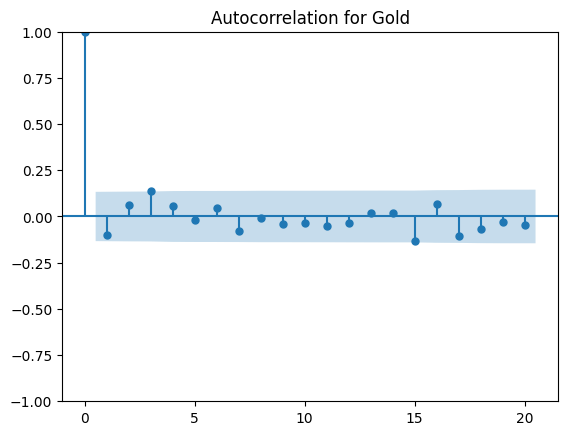

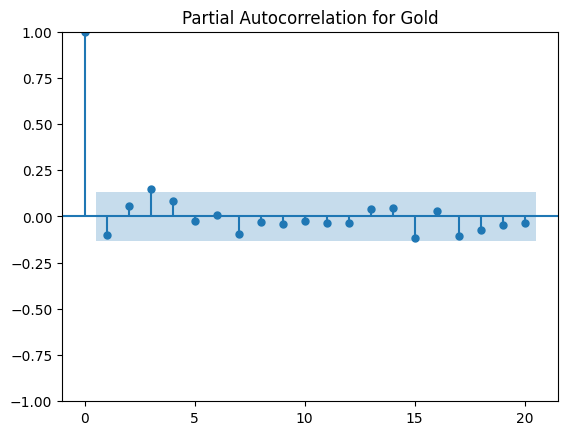

In [121]:
plot_autocorrelograms(diff_data, 'Gold')

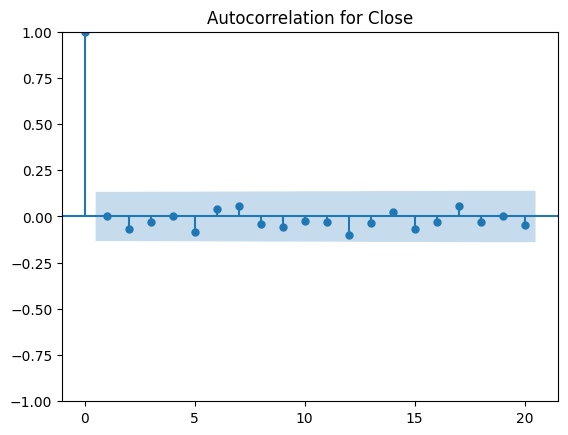

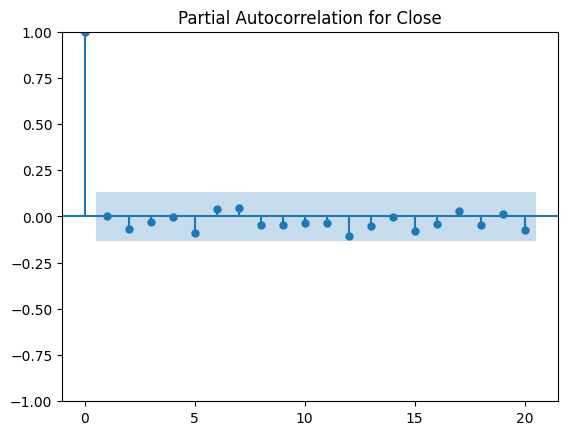

In [122]:
plot_autocorrelograms(diff_data, 'Close')

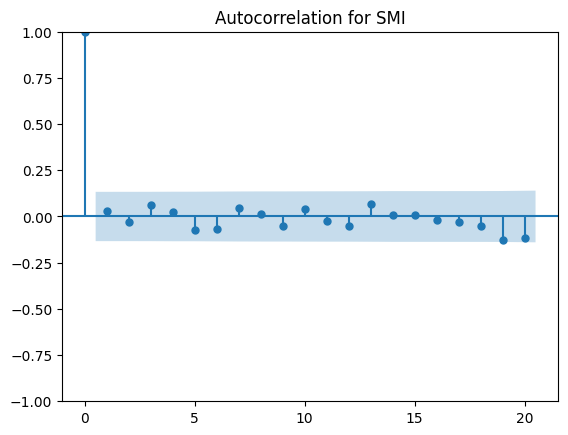

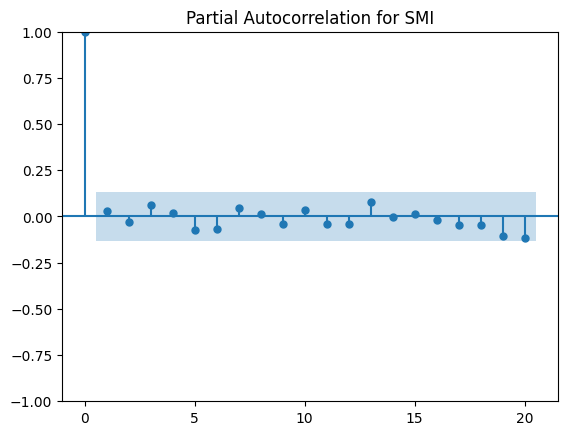

In [123]:
plot_autocorrelograms(diff_data, 'SMI')

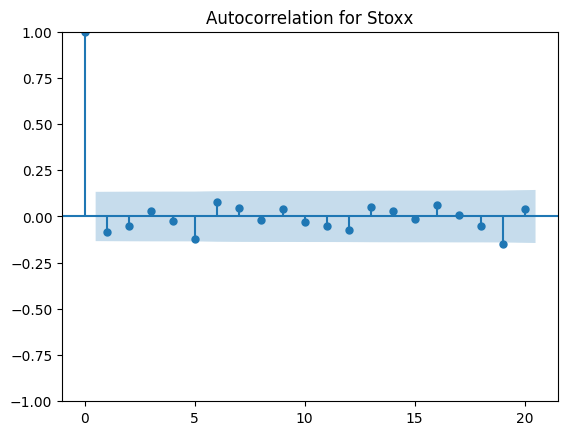

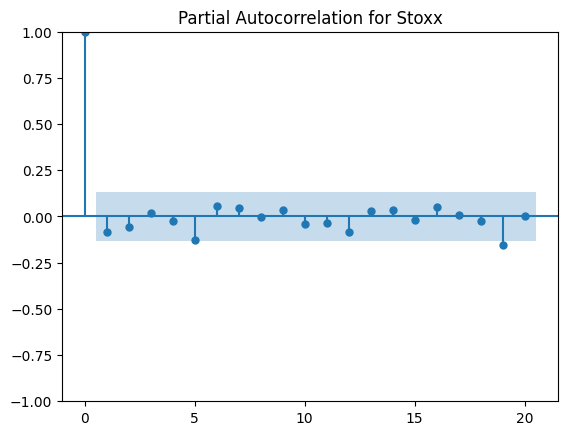

In [124]:
plot_autocorrelograms(diff_data, 'Stoxx')

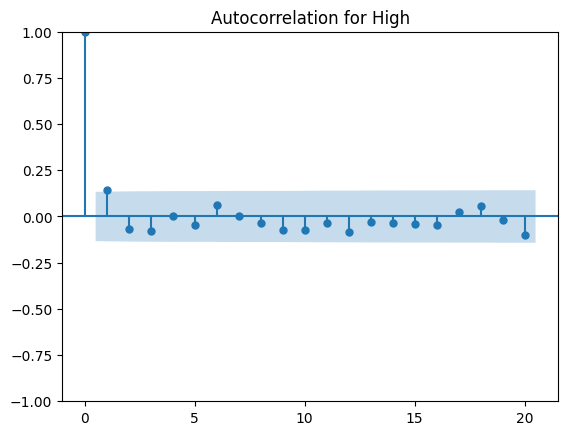

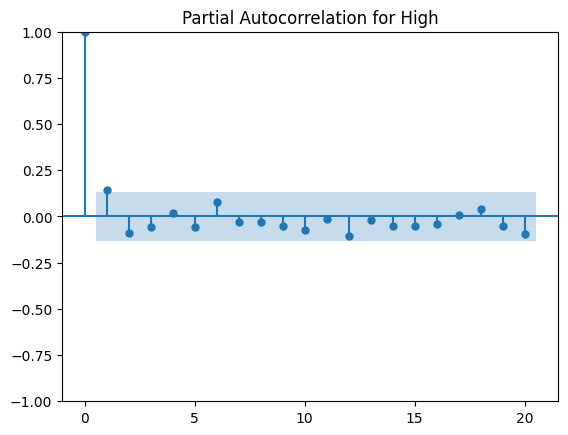

In [125]:
plot_autocorrelograms(diff_data, 'High')

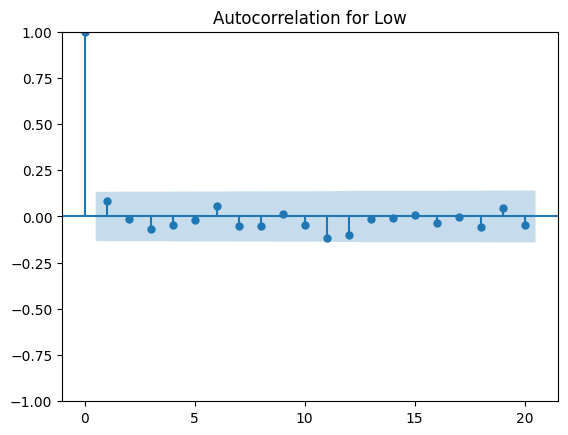

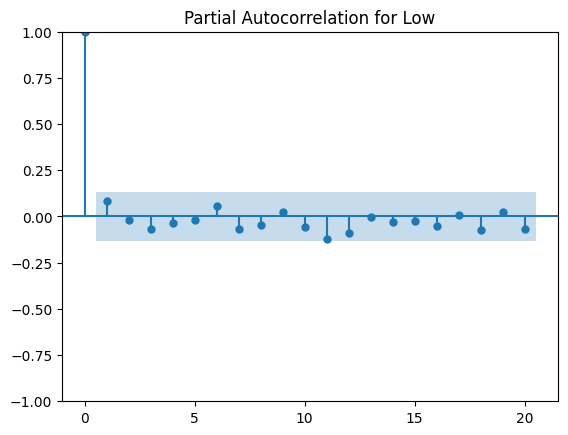

In [126]:
plot_autocorrelograms(diff_data, 'Low')

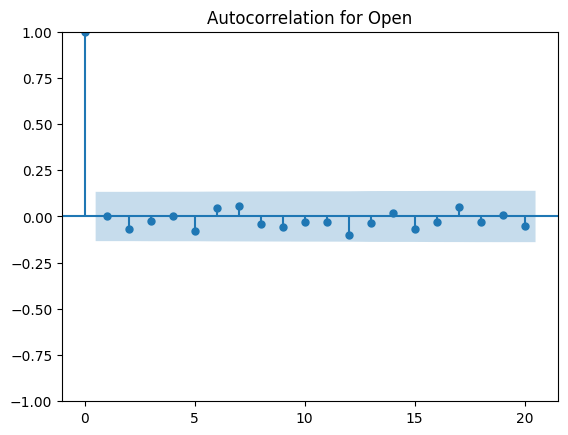

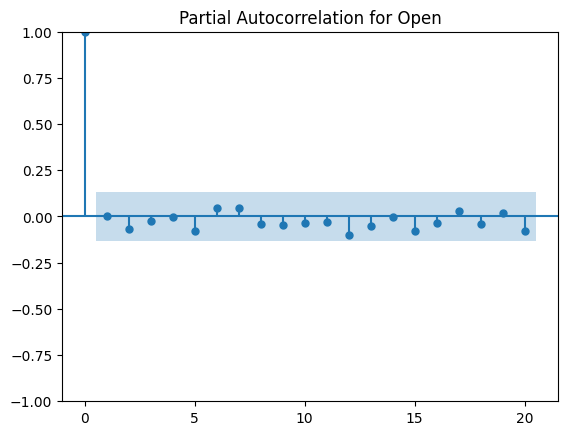

In [127]:
plot_autocorrelograms(diff_data, 'Open')

# Tests #

In [164]:
data = df.copy()
df = data.dropna()

train, test = df[:-5], df[-5:]

data = train

diff_data = diff(data, k_diff=1)
diff_test = diff(df[-6:], k_diff=1)

p = np.arange(1,2)
q = np.arange(2,3)
models = []
orders = []
MSEs = []
for i in tqdm(p):
    for j in q:
        orders.append((i,j))
        model = VARMAX(endog=diff_data[['Close','High', 'Open', 'Low']], order=(i,j), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse', exog=diff_data[['Gold', 'SMI', 'Stoxx']])
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['Gold', 'SMI', 'Stoxx']]).reset_index(drop=True).Close)
        pred['observed'] = test.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

100%|██████████| 1/1 [00:09<00:00,  9.22s/it]


In [165]:
idx = np.argmin(MSEs)
print(orders[idx])
model_fit = models[idx]

(1, 2)


Text(0.5, 1.0, 'MSE = 4.6296338944893106e-05')

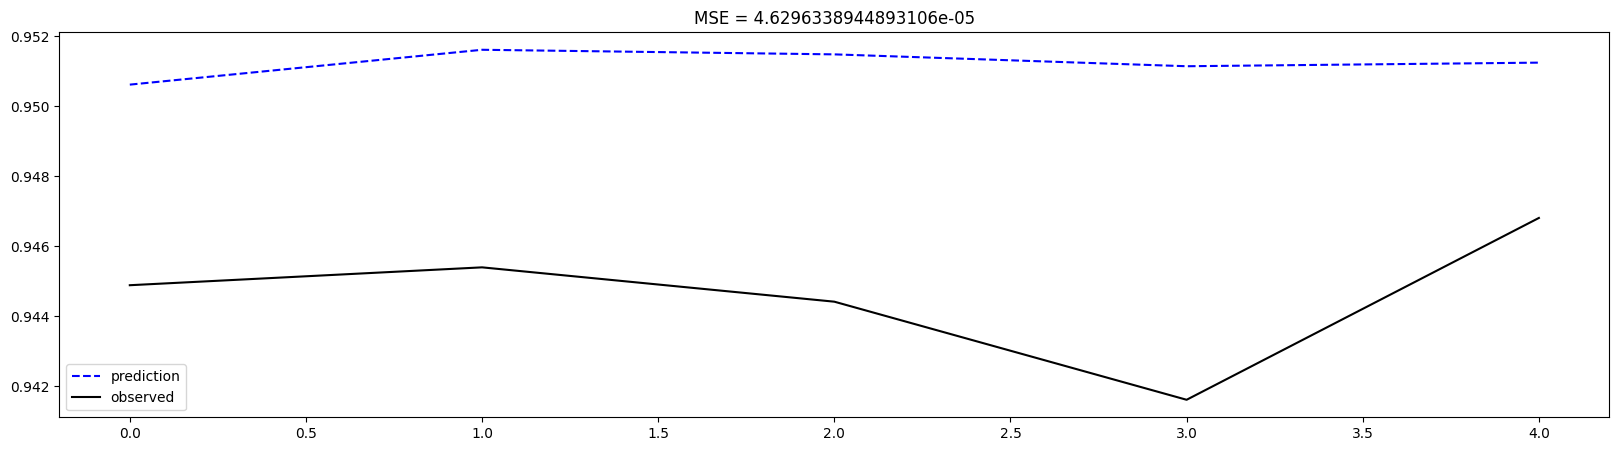

In [166]:
# plot prediction vs observed
pred = pd.DataFrame()
pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['Gold', 'Stoxx', 'SMI']]).reset_index(drop=True).Close)
pred['observed'] = test.reset_index(drop=True).Close

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

In [168]:
# Train all the data using the best p and q parameters
diff_data_all = diff(df, k_diff=1)
model = VARMAX(endog=diff_data_all[['Close','Gold', 'Stoxx', 'SMI']], order=(1, 2), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse')
model_fit_final = model.fit(disp=False)

In [176]:
forecast_vals = df.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['Gold', 'Stoxx', 'SMI']]).reset_index(drop=True).Close)
print(forecast_vals)

0    0.944716
1    0.945710
2    0.945579
3    0.945241
4    0.945343
Name: Close, dtype: float64


In [172]:
forecast_vals.values.tofile("./predictions_eurchf.csv", sep='\n')

Text(0.5, 1.0, 'MSE = 7.820797780500106e-05')

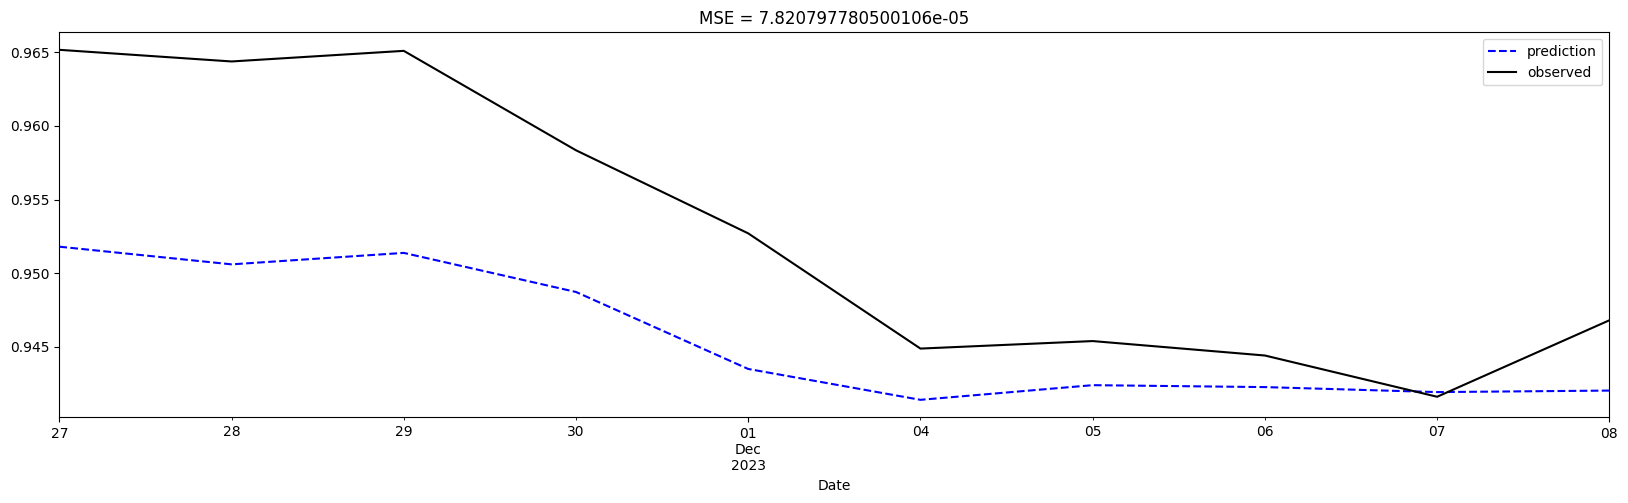

In [177]:
# plot prediction vs observed (last 2 weeks)
pred = pd.DataFrame()
temp = df.iloc[0]['Close'] + np.cumsum(model_fit.predict(start=0, end=diff_data.shape[0]+5-1, exog=diff_test[['Gold', 'Stoxx', 'SMI']]).Close)
pred['prediction'] = temp[-10:].reset_index(drop=True)
pred['observed'] = df.iloc[-10:]['Close'].reset_index(drop=True)
pred['Date'] = df.iloc[-10:]['Date'].reset_index(drop=True)

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'], x='Date')
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

In [178]:
print(pred)

   prediction  observed       Date
0    0.951807   0.96517 2023-11-27
1    0.950608   0.96438 2023-11-28
2    0.951386   0.96510 2023-11-29
3    0.948732   0.95835 2023-11-30
4    0.943506   0.95271 2023-12-01
5    0.941412   0.94489 2023-12-04
6    0.942406   0.94540 2023-12-05
7    0.942275   0.94442 2023-12-06
8    0.941937   0.94162 2023-12-07
9    0.942039   0.94681 2023-12-08
